In [1]:
# to add the spiking model codebase to the path
import sys
sys.path.append('..')

In [2]:
%matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

Using matplotlib backend: Qt5Agg


In [3]:
# goal: plot results of a learning run: average firing rate and weight changes

In [194]:
from results import Results
from plot import MidpointNormalize, weight_matrix
from generate import weight_matrix_from_flat_inds_weights

In [78]:
from brian2 import pA

In [216]:
plt.close('all')

In [114]:
# TODO: REMEMBER TO RE-RUN THE FIRST COUPLE WITH LESS SCALING TO MAKE SURE THAT'S THE PROBLEM

In [213]:
targetPath = 'C:/Users/mikejseay/Documents/BrianResults/'

# targetFile = 'jercogDefaultP05_2021-04-18-18-58_results'  # cross-homeo
# targetFile = 'jercogDefaultP05_2021-04-18-21-36_results'  # balance
# targetFile = 'jercogDefaultP05_2021-04-18-23-01_results'  # test

# targetFile = 'destexheDefaultP02_2021-04-19-22-43_results'  # cross-homeo

# weight changes customized separately
# targetFile = 'jercogDefault_1e3_P05_randn_2021-04-23-00-52_cross-homeo_results'  # starting from good weights?
# targetFile = 'jercogDefault_1e3_P05_randn_2021-04-23-01-17_cross-homeo_results'  # starting from bad weights
# targetFile = 'jercogDefault_1e3_P05_randn_2021-04-24-20-55_balance_results'  # starting from good weights?
# targetFile = 'jercogDefault_1e3_P05_randn_2021-04-25-15-07_balance_results'  # starting from bad weights
# targetFile = 'jercogDefault_1e3_P05_randn_2021-04-25-21-10_balance_results'  # starting from good weights?
# targetFile = 'jercogDefault_1e3_P05_randn_2021-04-26-08-56_balance_results'  # starting from good weights?
# targetFile = 'jercogDefault_1e3_P05_randn_2021-04-26-09-11_balance_results'  # starting from good weights, no weight change scaling
# targetFile = 'jercogDefault_1e3_P05_randn_2021-04-26-11-26_balance_results'  # starting from good weights, weight change scaling
# targetFile = 'jercogDefault_1e3_P05_randn_2021-04-26-14-10_balance_results'  # starting from good weights, weight change scaling with the membrane tau scaling
# targetFile = 'jercogDefault_1e3_P05_randn_2021-04-26-16-25_balance_results'  # starting from good weights, weight change scaling with the membrane tau scaling, alpha 10x
# targetFile = 'jercogDefault_1e3_P05_randn_2021-04-26-16-27_balance_results'  # carefully altered init weights (.75, 1.25, 1.5, 0.5), weight change scaling with the membrane tau scaling, alpha 10x
# targetFile = 'jercogDefault_1e3_P05_randn_2021-04-26-16-56_balance_results'  # random init weights, weight change scaling with the membrane tau scaling, alpha 10x

# targetFile = 'jercogDefault_1e3_P05_randn_repro_2021-04-27-18-23_balance_results'  # good params regained!!
# targetFile = 'jercogDefault_1e3_P05_randn_repro_2021-04-27-18-32_balance_results'  
# targetFile = 'jercogDefault_1e3_P05_randn_repro_2021-04-27-20-00_balance_results'
# targetFile = 'jercogDefault_1e3_P05_randn_repro_2021-04-27-20-04_balance_results'
# targetFile = 'jercogDefault_1e3_P05_randn_repro_2021-04-27-21-47_balance_results'
# targetFile = 'jercogDefault_1e3_P05_randn_repro_2021-04-28-06-22_balance_results'
# targetFile = 'jercogDefault_1e3_P05_randn_repro_2021-04-28-06-51_balance_results'

# at this point i realized that i had been initializing the weights wrong by swapping the EI and IE weights...

# targetFile = 'jercogDefault_1e3_P05_randn_repro_2021-04-28-09-42_balance_results'
# targetFile = 'jercogDefault_1e3_P05_randn_repro_2021-04-28-09-52_balance_results'
# targetFile = 'jercogDefault_1e3_P05_rand_2021-04-28-11-31_balance_results'
# targetFile = 'jercogDefault_1e3_P05_rand_2021-04-28-12-03_balance_results'

# targetFile = 'jercogDefault_1e3_P05_rand_2021-04-28-13-55_balance_results'
# targetFile = 'jercogDefault_1e3_P05_rand_2021-04-28-13-58_balance_results'

# targetFile = 'jercogDefault_1e3_P05_eqwts_noscale_2021-04-28-16-40_balance_results'
# targetFile = 'jercogDefault_1e3_P05_eqwts_halfscale_2021-04-28-16-40_balance_results'
targetFile = 'jercogDefault_1e3_P05_eqwts_noUnlessRefract_2021-04-28-21-30_balance_results'

In [214]:
R = Results()
R.init_from_file(targetFile, targetPath)
R.p['useRule']
importantInfoString = 'Name: {}\nEE: {}, IE: {}, EI: {}, II: {}\n tauFR={}, a1={} pA, a2={} pA, tauP={}'.format(R.rID,
    R.p['wEEScale'],R.p['wIEScale'],R.p['wEIScale'],R.p['wIIScale'],
    R.p['tauUpFRTrials'], R.p['alpha1'] / pA, R.p['alpha2'] / pA, R.p['tauPlasticityTrials'])

In [215]:
f, ax = plt.subplots(2, 1, sharex=True, figsize=(5, 9))

ax[0].plot(R.trialUpFRExc, label='E', color='g')
ax[0].plot(R.trialUpFRInh, label='I', color='r', alpha=.5)
ax[0].legend()
ax[0].hlines(R.p['setUpFRExc'], 0, len(R.trialUpFRExc), ls='--', color='g')
ax[0].hlines(R.p['setUpFRInh'], 0, len(R.trialUpFRInh), ls='--', color='r')
# ax[0].set_xlabel('Trial #')
ax[0].set_ylabel('Firing Rate (Hz)')
ax[0].set_ylim(0, 20)

ax[1].plot(R.trialwEE, label='wEE', color='cyan')
ax[1].plot(R.trialwIE, label='wIE', color='purple')
ax[1].plot(R.trialwEI, label='wEI', color='cyan', ls='--')
ax[1].plot(R.trialwII, label='wII', color='purple', ls='--')
ax[1].legend()
ax[1].set_xlabel('Trial #')
ax[1].set_ylabel('Weight (pA)')

f.suptitle(importantInfoString)

Text(0.5, 0.98, 'Name: jercogDefault_1e3_P05_eqwts_noUnlessRefract_2021-04-28-21-30_balance\nEE: 0.25, IE: 0.125, EI: 1.0, II: 0.5\n tauFR=2, a1=0.1 pA, a2=0.01 pA, tauP=500')

In [197]:
R.p

{'saveFolder': 'C:/Users/mikejseay/Documents/BrianResults/',
 'simName': 'jercogDefault_1e3_P05_rand',
 'saveWithDate': True,
 'dt': 100. * usecond,
 'duration': 1.5 * second,
 'updateMethod': 'euler',
 'reportType': 'stdout',
 'reportPeriod': 10. * second,
 'doProfile': False,
 'propSpikemon': 1,
 'recordStateVariables': ['v'],
 'indsRecordStateExc': [0, 799],
 'indsRecordStateInh': [0],
 'nUnits': 1000.0,
 'propInh': 0.2,
 'propConnect': 0.5,
 'propKicked': 0.1,
 'kickMode': 'Poisson',
 'kickTau': 0.5 * msecond,
 'kickDur': 2. * msecond,
 'kickLambda': 0.4 * second,
 'kickMinimumISI': 1. * second,
 'kickMaximumISI': 10. * second,
 'kickTimes': [100. * msecond],
 'kickSizes': [1],
 'kickAmplitudeExc': 2.2 * namp,
 'kickAmplitudeInh': 0.88 * namp,
 'noiseSigma': 2.5 * mvolt,
 'eLeakExc': 7.6 * mvolt,
 'eLeakInh': 6.5 * mvolt,
 'vResetExc': 14. * mvolt,
 'vResetInh': 14. * mvolt,
 'vThreshExc': 20. * mvolt,
 'vThreshInh': 20. * mvolt,
 'adaptTau': 0.5 * second,
 'adaptStrengthExc': 15. 

In [195]:
wEE = weight_matrix_from_flat_inds_weights(R.p['nExc'], R.p['nExc'], R.preInds_EE, R.postInds_EE, R.p['wEE_init'])
wIE = weight_matrix_from_flat_inds_weights(R.p['nExc'], R.p['nInh'], R.preInds_IE, R.postInds_IE, R.p['wIE_init'])
wEI = weight_matrix_from_flat_inds_weights(R.p['nInh'], R.p['nExc'], R.preInds_EI, R.postInds_EI, R.p['wEI_init'])
wII = weight_matrix_from_flat_inds_weights(R.p['nInh'], R.p['nInh'], R.preInds_II, R.postInds_II, R.p['wII_init'])

wFull = np.block([[wEE, wIE], [-wEI, -wII]])

fig7, ax7 = plt.subplots(num=7, figsize=(10, 9))
weight_matrix(ax7, wFull, xlabel='Pre Index', ylabel='Post Index', clabel='Normalized Weight',)

AttributeError: 'Results' object has no attribute 'preInds_EE'

In [190]:
f, ax = plt.subplots(2, 2)
axArr = ax.ravel()

dwMats = ('trialdwEEUnits',
          'trialdwEIUnits',
          'trialdwIEUnits',
          'trialdwIIUnits',
         )

for axInd, ax in enumerate(axArr):
    values = getattr(R, dwMats[axInd]).T
    i = ax.imshow(values,
                 cmap=plt.cm.RdBu_r,
                 aspect='auto',
                 interpolation='none')
    ax.set_xlabel('Trial #')
    ax.set_ylabel('Unit Index')
    
    vmax, vmin = np.max(values), np.min(values)
    norm = MidpointNormalize(vmin, vmax, 0)
    i.set_clim(vmin, vmax)
    i.set_norm(norm)
    
    cb = plt.colorbar(i, ax=ax)
    cb.ax.set_ylabel('Weight (pA)')
    ax.set_title(dwMats[axInd])
    

In [38]:
R.trialdwEEUnits.shape

(1597, 800)

In [42]:
R.trialdwEEUnits[:1500, :].min()

-20025.176

In [41]:
R.trialdwEEUnits.min()

-12101160.0

In [40]:
R.trialdwEEUnits.max()

3831.6306

In [ ]:
np.full()

In [26]:
test = np.empty((1500, 800,), dtype='float32')

In [126]:
test.size * test.itemsize / 1024 / 1024

4.57763671875

In [71]:
testSpikeInds = np.array([0, 1, 5, 2, 1, 4]).astype(int)
test = np.bincount(testSpikeInds)
test2 = np.bincount(testSpikeInds, minlength = 7)

In [72]:
test

array([1, 2, 1, 0, 1, 1], dtype=int64)

In [73]:
test2

array([1, 2, 1, 0, 1, 1, 0], dtype=int64)

In [25]:
nUnits = 10
pConn = 1
allowAutapses = False

In [33]:
bestNumberOfSynapses = int(np.round(pConn * nUnits ** 2))
print(bestNumberOfSynapses)

if allowAutapses:
    indicesFlat = np.random.choice(nUnits ** 2, bestNumberOfSynapses, replace=False)
else:
    probabilityArray = np.full((nUnits, nUnits), 1 / (nUnits * (nUnits - 1)))
    probabilityArray[np.diag_indices_from(probabilityArray)] = 0
    
    if pConn > (nUnits - 1) / nUnits:
        bestNumberOfSynapses -= int(np.round(nUnits ** 2 * (pConn - (nUnits - 1) / nUnits)))
        print(bestNumberOfSynapses)
    
    indicesFlat = np.random.choice(nUnits ** 2, bestNumberOfSynapses, replace=False, p=probabilityArray.ravel())

preInds, postInds = np.unravel_index(indicesFlat, (nUnits, nUnits))

100
90


In [32]:
int(np.round(nUnits ** 2 * (pConn - (nUnits - 1) / nUnits)))

10

In [28]:
int(np.round(((1 - pConn) * nUnits ** 2)))

0

In [ ]:
bestNumbe

In [4]:
# goal 2: apply normally distributed weights

In [15]:
nExc = 8
nInh = 2
pConn = 0.25
randnMean = 1
randnSD = 0.2

aEE = generate_adjacency_matrix_within(nExc, pConn, allowAutapses=False)
aIE = generate_adjacency_matrix_between(nExc, nInh, pConn)
aEI = generate_adjacency_matrix_between(nInh, nExc, pConn)
aII = generate_adjacency_matrix_within(nInh, pConn, allowAutapses=False)

wEE = w_from_a(aEE, randnMean, randnSD)
wIE = w_from_a(aIE, randnMean, randnSD)
wEI = w_from_a(aEI, randnMean, randnSD)
wII = w_from_a(aII, randnMean, randnSD)

In [16]:
wEE

array([[0.        , 1.14111646, 0.        , 0.        , 0.91245524,
        0.        , 0.        , 0.58845372],
       [0.        , 0.        , 0.        , 0.6840502 , 0.        ,
        0.        , 0.85097995, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.10777655],
       [1.32835325, 0.        , 0.        , 0.        , 0.93841501,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 1.06376324, 0.        , 0.        ,
        1.08381029, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.1919193 , 0.        ,
        0.        , 0.        , 0.70794324],
       [0.        , 1.26854389, 0.        , 0.8659907 , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.80745652, 0.        ,
        0.        , 1.12804687, 0.        ]])

In [6]:
preInds, postInds = np.where(aEE)

In [7]:
preInds 

array([0, 1, 1, 1, 1, 2, 2, 3, 3, 4, 5, 5, 6, 7, 7, 7], dtype=int64)

In [8]:
postInds

array([2, 0, 2, 4, 6, 4, 5, 1, 5, 5, 4, 6, 0, 0, 2, 4], dtype=int64)

In [11]:
weights = np.random.normal(size=preInds.size)

In [12]:
weights

array([ 0.54428341,  0.42842826, -0.1290585 , -1.68726729,  0.40761932,
       -0.48984529,  0.14953924,  0.58476359,  0.39997037,  1.15748391,
        0.325102  , -0.43593126, -1.13064903, -0.70461682,  1.49334686,
        0.0551257 ])

In [13]:
wEE[preInds, postInds] = weights

In [14]:
wEE

array([[ 0.        ,  0.        ,  0.54428341,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.42842826,  0.        , -0.1290585 ,  0.        , -1.68726729,
         0.        ,  0.40761932,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.48984529,
         0.14953924,  0.        ,  0.        ],
       [ 0.        ,  0.58476359,  0.        ,  0.        ,  0.        ,
         0.39997037,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.15748391,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.325102  ,
         0.        , -0.43593126,  0.        ],
       [-1.13064903,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [-0.70461682,  0.        ,  1.49334686,  0.        ,  0.0551257 ,
         0.        ,  0.        ,  0.        ]])

In [6]:
wFull = np.block([[wEE, wIE],[-wEI, -wII]])

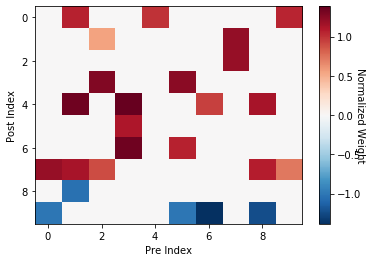

In [7]:
f, ax = plt.subplots()
weight_matrix(ax, wFull,
                   xlabel='Pre Index',
                   ylabel='Post Index',
                   clabel='Normalized Weight',)

In [174]:
f, ax = plt.subplots()
i = ax.imshow(wFull,
              cmap='RdBu_r',
              aspect='auto',
              interpolation='none', )
ax.set(xlabel='Post Index', ylabel='Pre Index')
cb = plt.colorbar(i, ax=ax)
cb.ax.set_ylabel('Normalized Weight', rotation=270)

Text(0, 0.5, 'Normalized Weight')

In [104]:
def method2():
    # more exact method
    nUnits = 10000
    pConn = 0.05
    allowAutapses = False

    bestNumberOfSynapses = int(np.round(pConn * nUnits ** 2))
    roughIndices = np.random.choice(nUnits ** 2, bestNumberOfSynapses, replace=False)
    adjMat = np.zeros((nUnits, nUnits), dtype=bool)
    adjMat[np.unravel_index(roughIndices, (nUnits, nUnits))] = True
    print(adjMat)
    traceRough = np.trace(adjMat)
    adjMat[np.diag_indices_from(adjMat)] = False
    nonDiagonalZeroBool = ~(np.eye(nUnits, dtype=bool) | adjMat)
    nonDiagonalIndicesFlattened = np.ravel_multi_index(np.where(nonDiagonalZeroBool), (nUnits, nUnits))
    newSynapseIndices = np.random.choice(nonDiagonalIndicesFlattened, traceRough, replace=False)
    adjMat[np.unravel_index(newSynapseIndices, (nUnits, nUnits))] = True

In [2]:
# goal 0: create a concise presentation of model parameters and compare two
# actually on second thought this doesn't really matter

importantParams = ['nUnits', 'propConnect', ]
from params import paramsJercog, paramsDestexhe
import pandas as pd
paramsJercog